$\textbf{Anwendungen auf Iris-Datensatz}\\ $ In diesem Notebook wollen wir unsere Ergebnisse der Beispieldatensätze zur Wahl des Ähnlichkeitsgraphen auf den Iris-Datensatz von Sir Ronald Fischer (1936) anwenden. Dieser
vierdimensionale Datensatz besteht aus jeweils 150 Datenpunkten, wobei jeweils 50
Datenpunkte einer von drei verschiedenen Iris-Spezies (Iris setosa, Iris virginica und
Iris versicolor) angehören. Jeder Datenpunkt hat vier Attribute: Sepal length, Sepal width, Petal length und Petal width.
Wir beginnen wir dem Import der notwendigen Bibliotheken und Funktionen.

In [4]:
#Wir implementieren zunächst alle nötigen Bibliotheken
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
from sklearn import datasets
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import radius_neighbors_graph
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx





In [5]:
def SC_kNN_Graph (Daten, SC, k, sigma):
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    A_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance', include_self = False).toarray()  #Adjazenzmatrix mit Gewichten d_{ij}
    A_knn_con = kneighbors_graph(Daten, n_neighbors=k, mode= 'connectivity', include_self = False).toarray() #ungewichtete Adjazenzmatrix

    #Wir benutzen die Gaußsche Ähnlichkeitsfkn., um Distanzen d_{ij} in Ähnlichkeiten umzuwandeln
    #Wir müssen aufpassen, dass wenn A_2_knn_{ij} = 0, dann  S_2_knn_{ij}= 0  ebenfalls, deshalb wenden wir erst 
    #Gaußkern eintragsweise an und multiplizieren dann erneut eintragsweise mit A_2_knn_con, damit Einträge, 
    #die null waren nun wieder null sind und nicht eins.
    S_knn = A_knn_con * np.exp(- A_knn_dis ** 2 / (2. * sigma ** 2)) #Ähnlichkeitsmatrix

    #Symmetrisieren der Ähnlichkeitsmatrix 
    for i in range(n):
        S_knn [i,i] = 0
        for j in range(i):
            max = np.maximum(S_knn[i,j], S_knn[j,i])
            S_knn[i,j] = max
            S_knn[j,i] = max
        
    
    
    #Erstelle Graphen
    G_knn = nx.from_numpy_array(S_knn , create_using=nx.Graph)
    
    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_knn)
    
    #label
    labels = SC.labels_
    
    #Gebe Graphen und label zurücl
    return(G_knn, labels)



#Mittelwertmethode:
def Mittelwertmethode (Daten, n):
    #Berechne kNN-Matrix mit Distanzen mit k wie oben angegeben
    k = int(np.ceil(np.log(n) +1)) #aufgerundetes k damit k integer
    
    #Adjazenzmatrix für knn-Graphen
    A_1_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance').toarray()
    
    #Mittelwert aller Einträge != 0 für jede Zeile, dies Eentspricht dem mittleren Abstand pro Knoten 
    #zu seinen k nächsten Nachbarn
    zeilen_mittelwert = np.sum(A_1_knn_dis, axis=1) /k 
    
    #mittelwert dieser Abstände
    mittelwert = np.mean(zeilen_mittelwert)
    
    return(mittelwert)




#Passe Clusterlabels so an, dass diese weitesgehend mit Original-labeling übereinstimmt
#Es gibt 6 verschiedene Möglichkeiten 3 Cluster mit den Zahlen {0,1,2} zu clusterfizieren
#0,1,2
#0,2,1
#1,0,2
#1,2,0
#2,0,1
#2,1,0
#Wir zählen dabei immer, wie viele Elemente bei welcher Variante falsch zugeordnet wurden und nehmen am Schluss
#die Variante, die der Originalzurdnung am besten entspricht


def beste_labelung (Original_label, cluster_label):
    
    #1. Varinate: Zuordnung wie vom Algorithmus zurückgegeben
    min = np.count_nonzero(Original_label - cluster_label)
    beste_label = cluster_label
    
    
    #2. Variante: 0->1, 1->2, 2->0:  
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)
        
        
    #3. Variante: 0->1, 1->0, 2->2:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=2
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #4. Variante: 0->2, 1->0, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

     #5. Variante: 0->2, 1->1, 2->0:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=1
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #6. Variante: 0->0, 1->2, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=0
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)



    return(min, beste_label)


Zunächst wollen wir den Datensatz vernünftig plotten. Dazu wählen wir uns zunächst jeweils zwei der vier Attribute und plotten diese gegeneinander als Scatterplot. Danach machen wir das gleiche mit jeweils drei der vier Attribute.

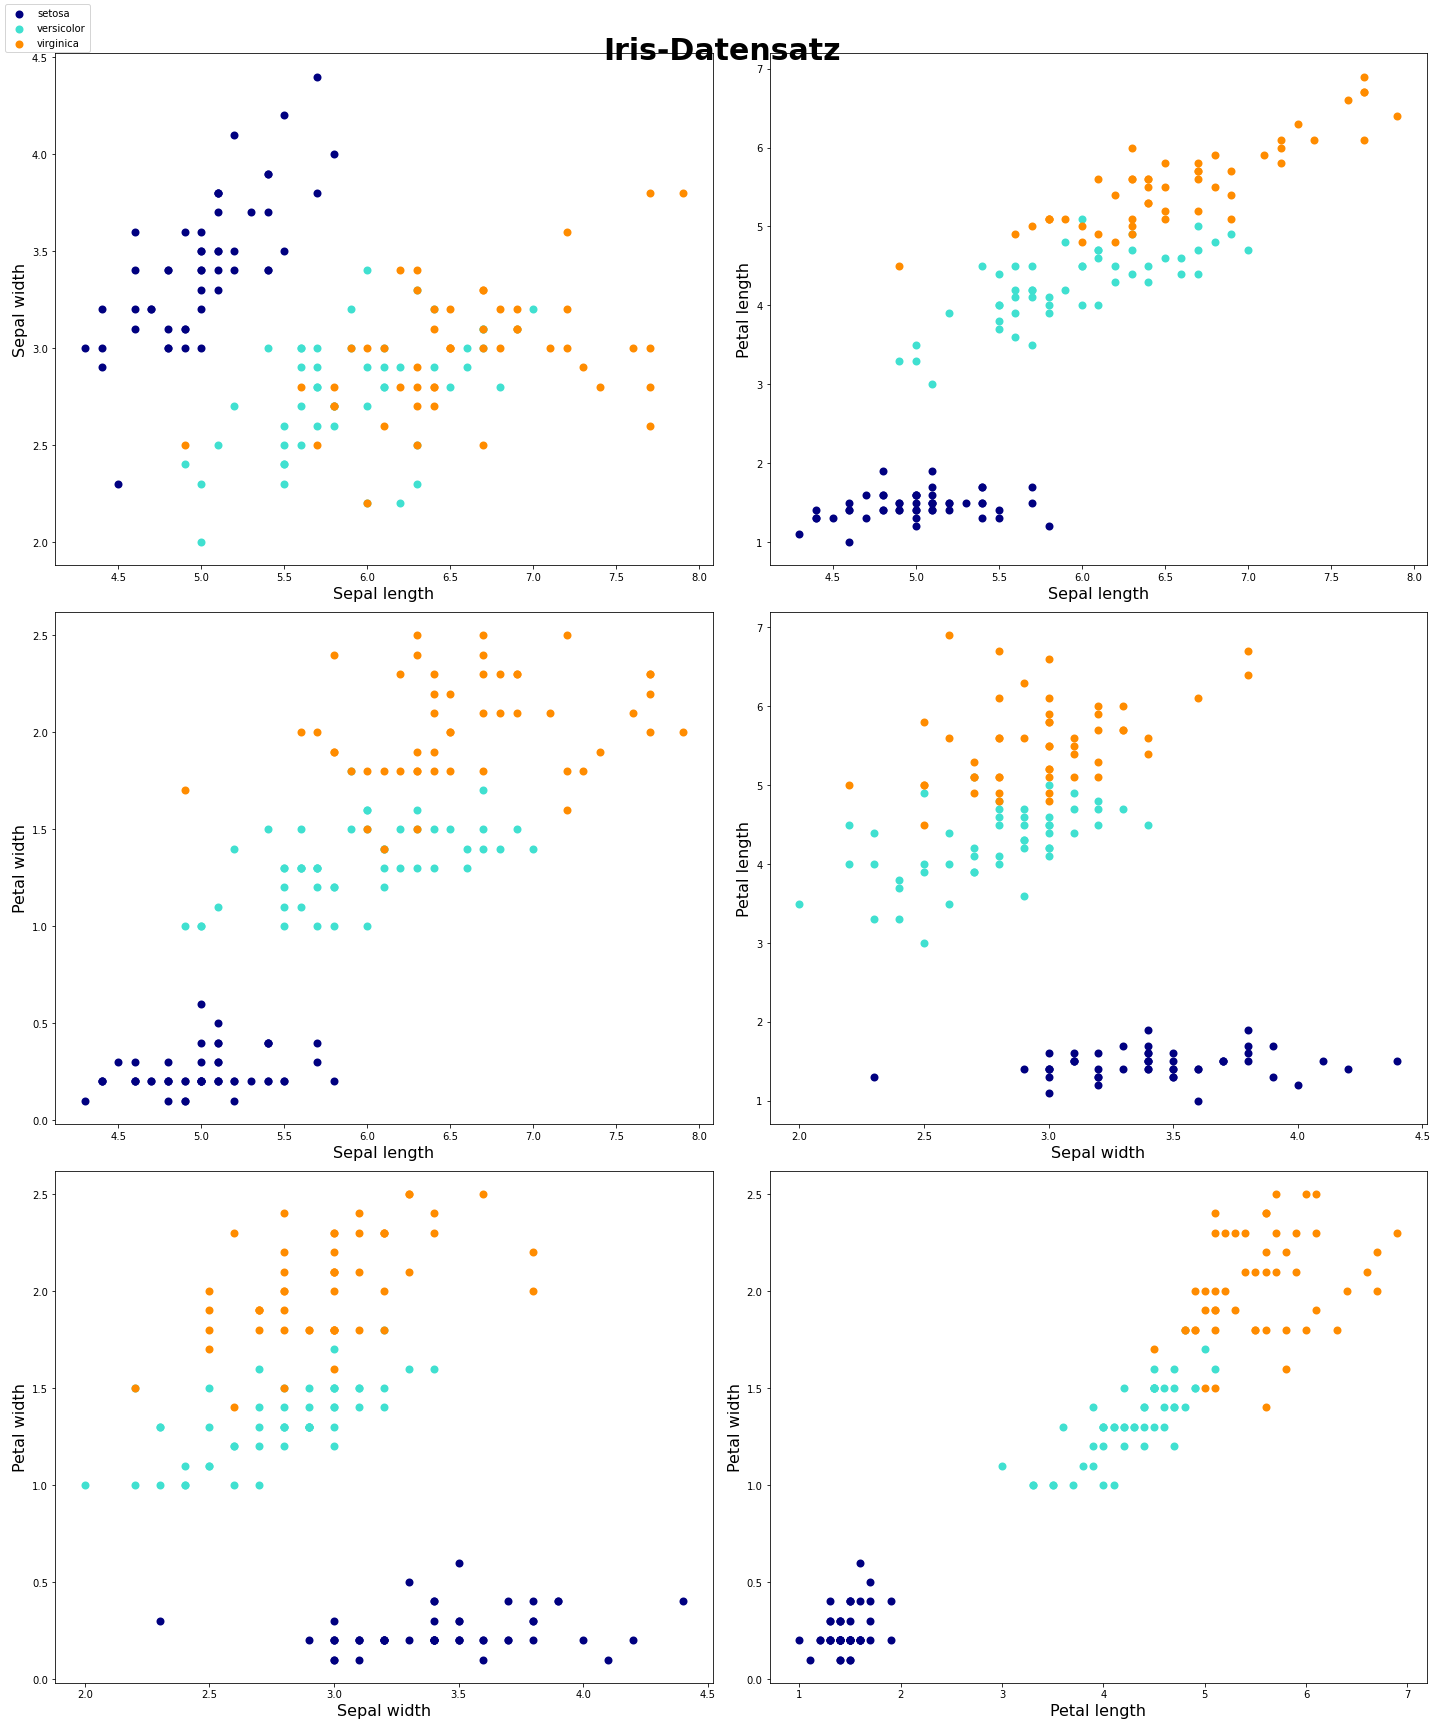

In [6]:
#Wir laden den Datensatz
iris = datasets.load_iris()
Daten = iris.data  #Daten aus dem R^4
Zugehörigkeit = iris.target #Originale Zugehörigkeit zu den 3 Arten

#Plotte jeweils alle Kobinationen von 2d Scatter plots

colors = ["navy", "turquoise", "darkorange"] #Farben für die jeweiligen Arten

#3x 2 Plots
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(20,24))



#ax[0,0].set_title('Iris : Zwei Monde uns ein Blob mit korrekter Zuordnung', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[0,0].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 1],
            color=color,
            lw=2,
            label=target_name,
        )
#ax[0,0].legend(loc="best", shadow=False, scatterpoints=1)
ax[0,0].set_xlabel("Sepal length", size = 16)
ax[0,0].set_ylabel("Sepal width", size = 16)

#ax[0,1].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[0,1].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 2],
            color=color,
            lw=2,
            label=target_name,
        )
ax[0,1].set_xlabel("Sepal length", size = 16)
ax[0,1].set_ylabel("Petal length", size = 16)



#ax[1,0].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[1,0].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 3],
            color=color,
            lw=2,
            label=target_name,
        )
ax[1,0].set_xlabel("Sepal length", size = 16)
ax[1,0].set_ylabel("Petal width", size = 16)



#ax[1,1].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[1,1].scatter(
            Daten[Zugehörigkeit == i, 1],
            Daten[Zugehörigkeit == i, 2],
            color=color,
            lw=2,
            label=target_name,
        )
ax[1,1].set_xlabel("Sepal width", size = 16)
ax[1,1].set_ylabel("Petal length", size = 16)



#ax[2,0].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[2,0].scatter(
            Daten[Zugehörigkeit == i, 1],
            Daten[Zugehörigkeit == i, 3],
            color=color,
            lw=2,
            label=target_name,
        )
ax[2,0].set_xlabel("Sepal width", size = 16)
ax[2,0].set_ylabel("Petal width", size = 16)



#ax[2,1].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[2,1].scatter(
            Daten[Zugehörigkeit == i, 2],
            Daten[Zugehörigkeit == i, 3],
            color=color,
            lw=2,
            label=target_name,
        )
ax[2,1].set_xlabel("Petal length", size = 16)
ax[2,1].set_ylabel("Petal width", size = 16)


handles, labels = ax[2,1].get_legend_handles_labels()
fig.suptitle('Iris-Datensatz', fontsize=30, fontweight='demi')
fig.legend(handles, labels, loc='upper left')

fig.tight_layout()

plt.show()


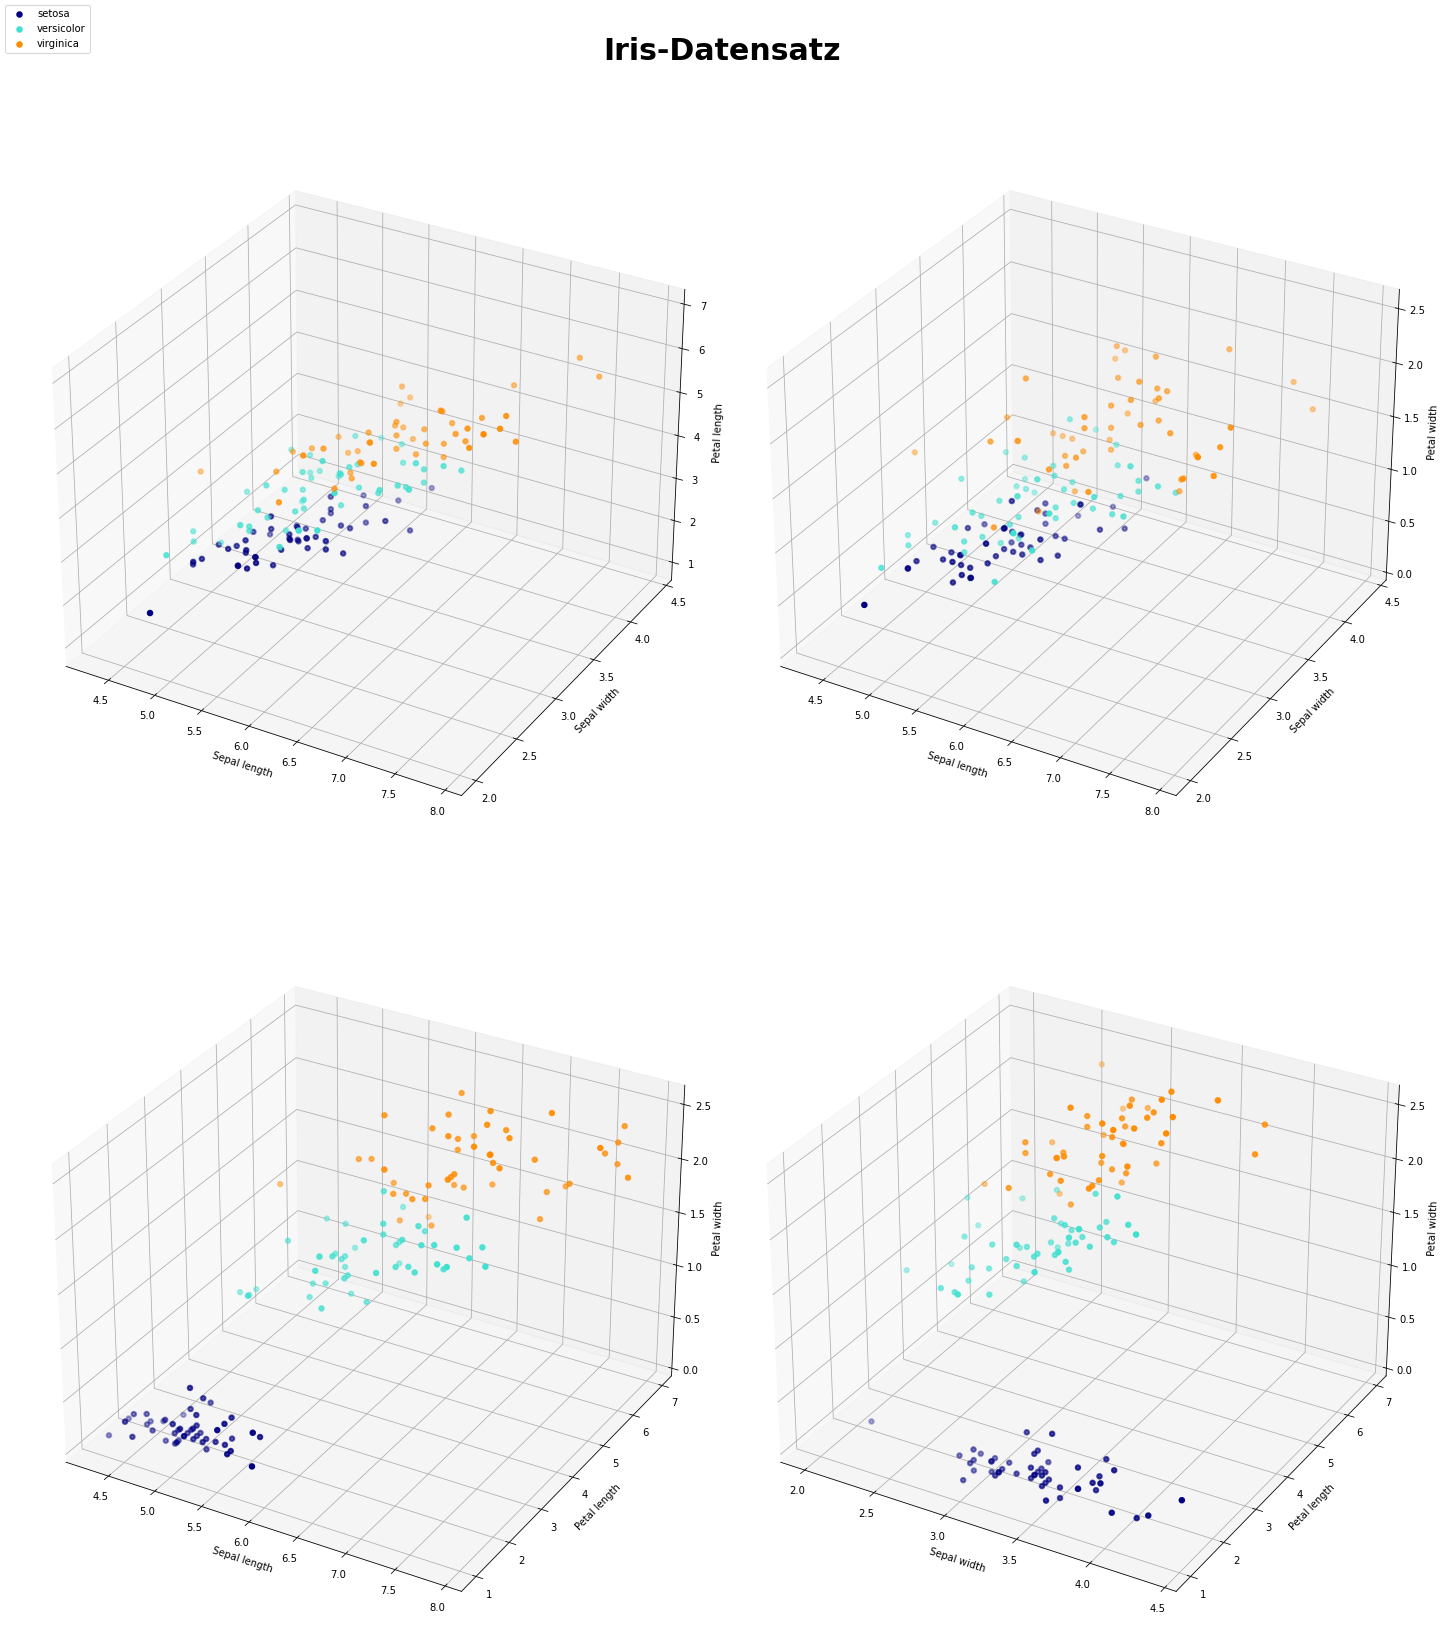

In [7]:
#Nun drei dimensionale Darstellung:

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,24), subplot_kw={'projection': '3d'})
                       

for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[0,0].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 1],
            Daten[Zugehörigkeit == i, 2],
            color = color,
            lw=2,
            label=target_name
        )
ax[0,0].set_xlabel('Sepal length')
ax[0,0].set_ylabel('Sepal width')
ax[0,0].set_zlabel('Petal length')



for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[0,1].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 1],
            Daten[Zugehörigkeit == i, 3],
            color = color,
            lw=2,
            label=target_name
        )
ax[0,1].set_xlabel('Sepal length')
ax[0,1].set_ylabel('Sepal width')
ax[0,1].set_zlabel('Petal width')



for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[1,0].scatter(
            Daten[Zugehörigkeit == i, 0],
            Daten[Zugehörigkeit == i, 2],
            Daten[Zugehörigkeit == i, 3],
            color = color,
            lw=2,
            label=target_name
        )
ax[1,0].set_xlabel('Sepal length')
ax[1,0].set_ylabel('Petal length')
ax[1,0].set_zlabel('Petal width')


for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        ax[1,1].scatter(
            Daten[Zugehörigkeit == i, 1],
            Daten[Zugehörigkeit == i, 2],
            Daten[Zugehörigkeit == i, 3],
            color = color,
            lw=2,
            label=target_name
        )
ax[1,1].set_xlabel('Sepal width')
ax[1,1].set_ylabel('Petal length')
ax[1,1].set_zlabel('Petal width')


handles, labels = ax[1,1].get_legend_handles_labels()
fig.suptitle('Iris-Datensatz', fontsize=30, fontweight='demi')
fig.legend(handles, labels, loc='upper left')

fig.tight_layout()

plt.show()


Nun wollen wir den $k$NN-Graphen mit Parametern aus der Mittelwertmethode auf den Datensatz anwenden.

In [8]:
#wir Erstellen Objekt der Klasse SpectralClustering, das wir für das Clustering mit kNN- und Epsilon-Graphen benutzen werden
SC_1 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels= 'kmeans')


In [9]:
#Wähle k und sigma durch Mittelwertmethode
k_1 =  int(np.ceil(np.log(Daten.shape[0]) +1))
sigma_1 = Mittelwertmethode(Daten, Daten.shape[0])

print('k = ', k_1, ', sigma = ', sigma_1)

G_knn_1, Daten_knn_labels_1 = SC_kNN_Graph(Daten, SC_1, k = k_1, sigma = sigma_1)

Anzahl_falsch, Daten_knn_labels_1 = beste_labelung(Zugehörigkeit, Daten_knn_labels_1)

k =  7 , sigma =  0.39175271596704897


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [10]:
#k-means Clustering zum Vergleich:
km = KMeans(n_clusters=3)
km.fit(Daten)

Anzahl_falsch_km , km_labels = beste_labelung(Zugehörigkeit, km.labels_)


Wir betrachten die Ergebnisse des Spectralen Clusterings, indem wir drei der sechs verschiedenen 2d-Darstellungen das Datensatzes von oben wählen und mit diesen den Graphen und das Clustering plotten. 

136 der 150 Punkte wurden durch das Spectrale Clustering den 3 Sorten richtig zugeordnet.
 14  Punkte wurden falsch zugeordnet, dies entspricht 9.333333333333334 % aller Punkte.
 Zum Vergleich: Durch k-means wurden  134  Datenpunkte richtig und 16  Datenpunkte falsch zugeordnet.


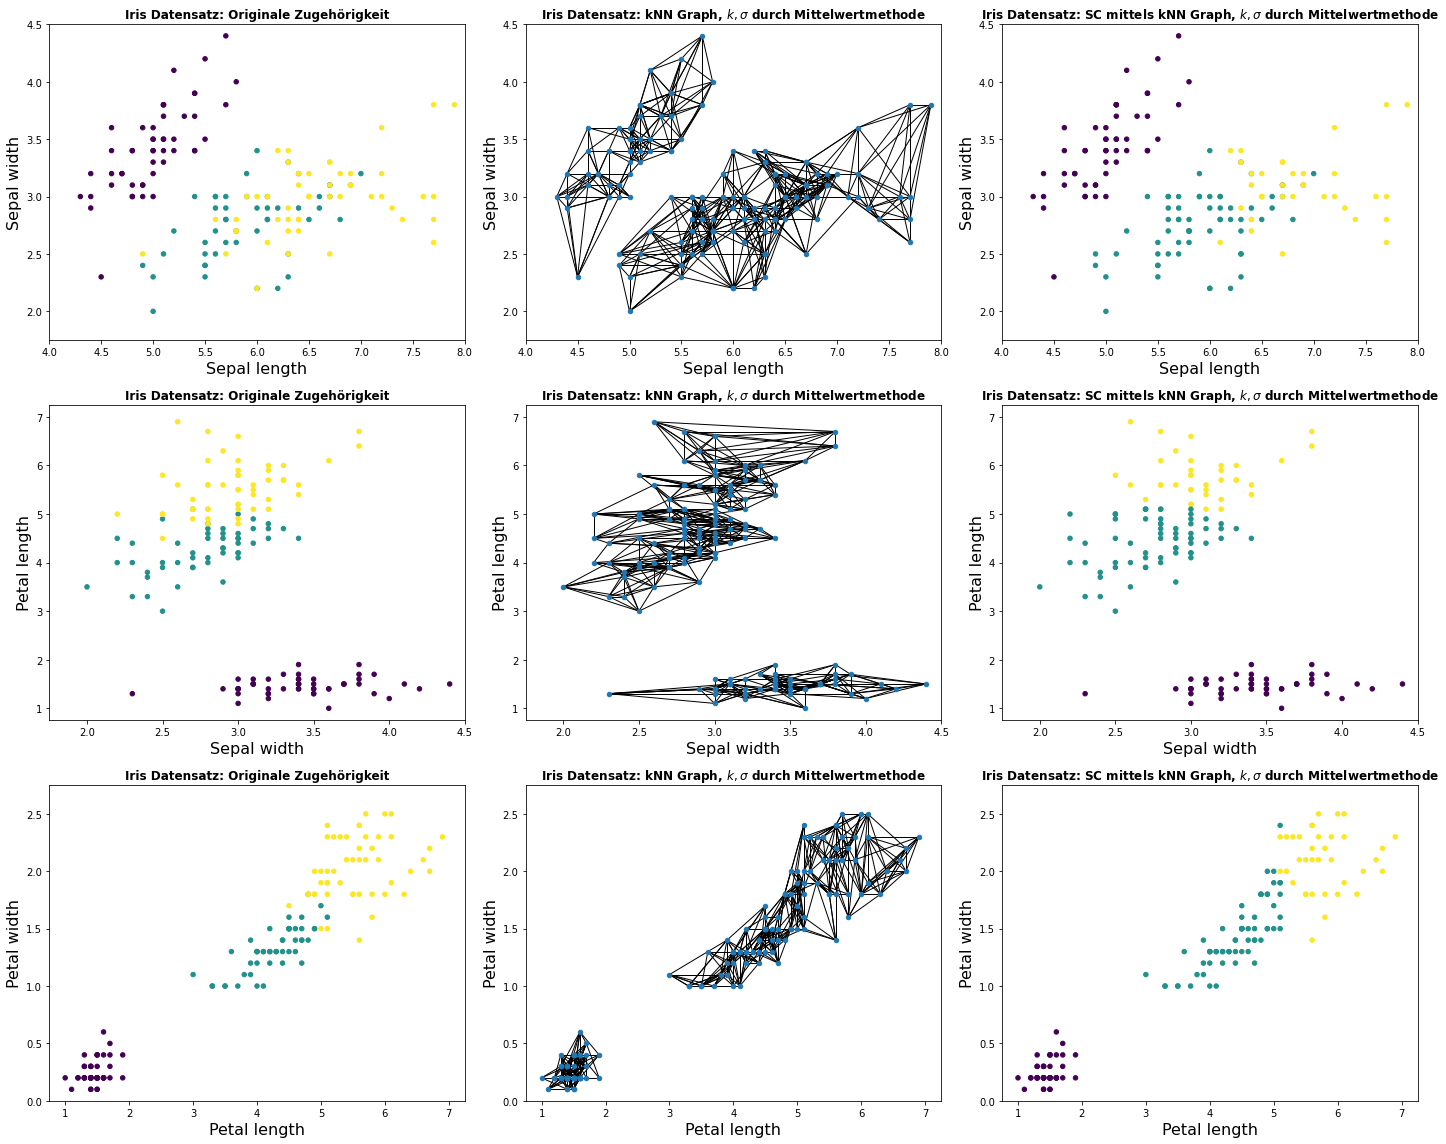

In [11]:
print(150 -Anzahl_falsch, 'der 150 Punkte wurden durch das Spectrale Clustering den 3 Sorten richtig zugeordnet.\n', 
      Anzahl_falsch, ' Punkte wurden falsch zugeordnet, dies entspricht', Anzahl_falsch/150 * 100, '% aller Punkte.\n'
     ' Zum Vergleich: Durch k-means wurden ' , 150 - Anzahl_falsch_km, ' Datenpunkte richtig und' , Anzahl_falsch_km, 
     ' Datenpunkte falsch zugeordnet.')
    

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20,16))

## Sepal length vs. Sepal width:
#Position jedes Knotens in der Ebene
pos= {}
for i in range (150):
    pos[i] = (Daten[i, 0], Daten[i, 1])  
    
ax[0,0].set_title('Iris Datensatz: Originale Zugehörigkeit', fontsize=12, fontweight='demi')
ax[0,0].scatter(Daten[:, 0], Daten[:, 1], s= 20, c=  Zugehörigkeit, cmap = 'viridis')
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,0].set_xlabel("Sepal length", size = 16)
ax[0,0].set_ylabel("Sepal width", size = 16)
ax[0,0].set_xlim([4, 8])
ax[0,0].set_ylim([1.75, 4.5])

    
ax[0,1].set_title('Iris Datensatz: kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
nx.draw(G_knn_1,  pos = pos, node_size = 20,ax=ax[0,1] )
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,1].set_xlabel("Sepal length", size = 16)
ax[0,1].set_ylabel("Sepal width", size = 16)
ax[0,1].set_xlim([4, 8])
ax[0,1].set_ylim([1.75, 4.5])
    
ax[0,2].set_title('Iris Datensatz: SC mittels kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
ax[0,2].scatter(Daten[:, 0], Daten[:, 1], s= 20, c=  Daten_knn_labels_1, cmap = 'viridis')
ax[0,2].set_axis_on()
ax[0,2].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,2].set_xlabel("Sepal length", size = 16)
ax[0,2].set_ylabel("Sepal width", size = 16)
ax[0,2].set_xlim([4, 8])
ax[0,2].set_ylim([1.75, 4.5])


##Sepal width vs. Petal length
#Position jedes Knotens in der Ebene
pos= {}
for i in range (150):
    pos[i] = (Daten[i, 1], Daten[i, 2])  
    
ax[1,0].set_title('Iris Datensatz: Originale Zugehörigkeit', fontsize=12, fontweight='demi')
ax[1,0].scatter(Daten[:, 1], Daten[:, 2], s= 20, c=  Zugehörigkeit, cmap = 'viridis')
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,0].set_xlabel("Sepal width", size = 16)
ax[1,0].set_ylabel("Petal length", size = 16)
ax[1,0].set_xlim([1.75, 4.5])
ax[1,0].set_ylim([0.75, 7.25])
    
ax[1,1].set_title('Iris Datensatz: kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
nx.draw(G_knn_1,  pos = pos, node_size = 20,ax=ax[1,1] )
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,1].set_xlabel("Sepal width", size = 16)
ax[1,1].set_ylabel("Petal length", size = 16)
ax[1,1].set_xlim([1.75, 4.5])
ax[1,1].set_ylim([0.75, 7.25])
    
ax[1,2].set_title('Iris Datensatz: SC mittels kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
ax[1,2].scatter(Daten[:, 1], Daten[:, 2], s= 20, c=  Daten_knn_labels_1, cmap = 'viridis')
ax[1,2].set_axis_on()
ax[1,2].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,2].set_xlabel("Sepal width", size = 16)
ax[1,2].set_ylabel("Petal length", size = 16)
ax[1,2].set_xlim([1.75, 4.5])
ax[1,2].set_ylim([0.75, 7.25])



## Petal length vs. Petal width"
#Position jedes Knotens in der Ebene
pos= {}
for i in range (150):
    pos[i] = (Daten[i, 2], Daten[i, 3])  
    
ax[2,0].set_title('Iris Datensatz: Originale Zugehörigkeit', fontsize=12, fontweight='demi')
ax[2,0].scatter(Daten[:, 2], Daten[:, 3], s= 20, c=  Zugehörigkeit, cmap = 'viridis')
ax[2,0].set_axis_on()
ax[2,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[2,0].set_xlabel("Petal length", size = 16)
ax[2,0].set_ylabel("Petal width", size = 16)
ax[2,0].set_xlim([0.75, 7.25])
ax[2,0].set_ylim([0,2.75])
    
ax[2,1].set_title('Iris Datensatz: kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
nx.draw(G_knn_1,  pos = pos, node_size = 20,ax=ax[2,1] )
ax[2,1].set_axis_on()
ax[2,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[2,1].set_xlabel("Petal length", size = 16)
ax[2,1].set_ylabel("Petal width", size = 16)
ax[2,1].set_xlim([0.75, 7.25])
ax[2,1].set_ylim([0,2.75])

ax[2,2].set_title('Iris Datensatz: SC mittels kNN Graph, $k,\sigma$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
ax[2,2].scatter(Daten[:, 2], Daten[:, 3], s= 20, c=  Daten_knn_labels_1, cmap = 'viridis')
ax[2,2].set_axis_on()
ax[2,2].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[2,2].set_xlabel("Petal length", size = 16)
ax[2,2].set_ylabel("Petal width", size = 16)
ax[2,2].set_xlim([0.75, 7.25])
ax[2,2].set_ylim([0 , 2.75])


fig.tight_layout()

Zum Abschluss wollen wir noch genauer identifizieren, welche Punkte falsch zugeordnet wurden. Dazu zählen wir jeweils, wie viele Pflanzen jeder Sorte welchem Cluster zugordnet wurden.
Betrachten wir dazu kurz die Originalzugehörigkeit der Daten:

In [12]:
print(Zugehörigkeit)
print(iris.target_names)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']


Wir sehen, dass die ersten 50 Punkte der Spezies "iris setosa", die nächsten 50 der Spezies "iris versicolor" und die letzten 50 der Spezies "rirs virginica" angehören. Wir zählen nun in drei Arrays, bestehend jeweils aus drei Einträgen, wie viele Datenpunkte der jeweiligen Spezies, welchem Cluster zugeordnet wurden und erzeugen aus diesen eine Tabelle.

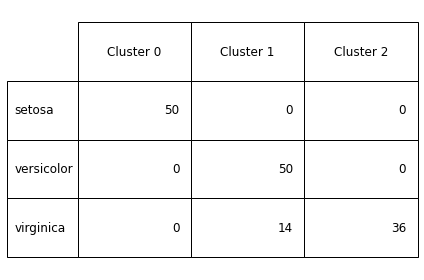

In [15]:
setosa_cluster = [0,0,0]
versicolor_cluster = [0,0,0]
virginica_cluster = [0,0,0]


setosa_labels = Daten_knn_labels_1[:50] #ersten 50 Einträge von label-Array entsprechen Labelung für die setosa Spezies
versicolor_labels = Daten_knn_labels_1[50:100] #Einträge 51 bis 100 entsprechen Labelung für die versicolor Spezies
virginica_labels = Daten_knn_labels_1[100:150] #Einträge 101 bis 150 entsprechen Labelung für die virginica Spezies

setosa_cluster[0] = len(setosa_labels[setosa_labels == 0]) #setosa Pflanzen, die Cluster 0 zugeordnet wurden
setosa_cluster[1] = len(setosa_labels[setosa_labels == 1]) #setosa Pflanzen, die Cluster 1 zugeordnet wurden
setosa_cluster[2] = len(setosa_labels[setosa_labels == 2]) #setosa Pflanzen, die Cluster 2 zugeordnet wurden
 
versicolor_cluster[0] = len(versicolor_labels[versicolor_labels == 0]) #versicolor Pflanzen, die Cluster 0 zugeordnet wurden
versicolor_cluster[1] = len(versicolor_labels[versicolor_labels == 1]) #versicolor Pflanzen, die Cluster 1 zugeordnet wurden
versicolor_cluster[2] = len(versicolor_labels[versicolor_labels == 2]) #versicolor Pflanzen, die Cluster 2 zugeordnet wurden

virginica_cluster[0] = len(virginica_labels[virginica_labels == 0]) #virginica Pflanzen, die Cluster 0 zugeordnet wurden
virginica_cluster[1] = len(virginica_labels[virginica_labels == 1]) #virginica Pflanzen, die Cluster 1 zugeordnet wurden
virginica_cluster[2] = len(virginica_labels[virginica_labels == 2]) #virginica Pflanzen, die Cluster 2 zugeordnet wurden



Spalten = ( 'Cluster 0', 'Cluster 1', 'Cluster 2')
Zeilen = ('setosa' , 'versicolor', 'virginica')
cellText = [setosa_cluster, versicolor_cluster, virginica_cluster]

fig, ax = plt.subplots()
table = ax.table(cellText=cellText, loc='center', rowLabels=Zeilen, colLabels=Spalten)


table.set_fontsize(12)
table.scale(1,4)
ax.axis('off')


fig.tight_layout()
plt.show()


Wir sehen, dass wir mittels Spectralem Clustering die 'setosa' Spezies korrekt einem Cluster zuordnen konnten. Die 'versicolor' und 'virginica' Spezies konnten wir dagegen nicht perfekt trennen. Die 'versicolor'-Pflanzen befinden sich zwar alle im gleichen Cluster, gleichzeitig befinden sich in diesem aber auch 14 Pflanzen der Gattung 'virginica'.

Der Folgende Code dient nur zum Abspeichern der Tabelle zum Verwenden in der Arbeit. Diese entspricht Abbildung 8 in der Arbeit.

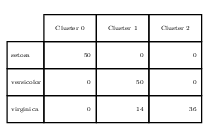

In [16]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
   "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

cellText = [setosa_cluster, versicolor_cluster, virginica_cluster]

fig, ax = plt.subplots()
table = ax.table(cellText=cellText, loc='center', rowLabels=Zeilen, colLabels=Spalten)


table.set_fontsize(6)
table.scale(1,4)
ax.axis('off')

#fig.suptitle('Zuordnungen der Spezies zu den Clustern',  fontsize=5, fontweight='demi' )
fig.tight_layout()
fig.set_size_inches(3, 2)
fig.tight_layout()


plt.savefig('Iris.pdf')
#plt.show()
